In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import random
import math
from scipy.spatial import distance

In [14]:
def RGBGray(image, rows, cols):
    imagenGray = np.zeros((rows, cols), dtype=np.uint8)
    B = image[:, :, 0] # Separa los canales de la imagen 
    G = image[:, :, 1]
    R = image[:, :, 2]

    # for i in range(rows):
    #     for j in range(cols):
    #         imagenGray[i, j] = 0.299*R[i, j] + 0.587*G[i, j] + 0.114*B[i, j] # Aplica estandar NTSC
    imagenGray = 0.299*R + 0.587*G + 0.114*B # Aplica estandar NTSC

    return np.uint8(imagenGray)

def expandImage(image, sizeKernel, dtype):
    sizeExpand = sizeKernel - 1
    rowsExpandedImage = image.shape[0] + sizeExpand
    colsExpandedImage = image.shape[1] + sizeExpand
    expandedImage = np.zeros((rowsExpandedImage, colsExpandedImage), dtype=dtype)
    # print("\nTamaño imagen expandida: " + str(rowsExpandedImage) + " x " + str(colsExpandedImage))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            expandedImage[i + int(sizeExpand / 2), j + int(sizeExpand / 2)] = image[i, j]
    
    return expandedImage

def passKernel(originalImage, expandedImage, kernel, sizeKernel):
    expandedImage = np.float64(expandedImage)
    passKernelImage = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.float64)

    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            result = 0
            for k in range(sizeKernel):
                for l in range(sizeKernel):
                    indexExpandedImagei = i + k
                    indexExpandedImagej = j + l
                    result += expandedImage[indexExpandedImagei, indexExpandedImagej] * kernel[k, l]
            # passKernelImage[i, j] = result / np.sum(kernel)
            passKernelImage[i, j] = result

    return passKernelImage	

def crossingZero(originalImage, expandedImage, sizeKernel):
    auxMatrix = np.zeros((expandedImage.shape[0], expandedImage.shape[1]), dtype=np.uint8)
    crossingZeroImage = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.uint8)
    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            for k in range(sizeKernel):
                for l in range(sizeKernel):
                    indexExpandedImagei = i + k
                    indexExpandedImagej = j + l
                    multiplication = expandedImage[i + 1, j + 1] * expandedImage[indexExpandedImagei, indexExpandedImagej]
                    if multiplication < 0:
                        auxMatrix[indexExpandedImagei, indexExpandedImagej] = np.uint8(255)

    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            crossingZeroImage[i, j] = auxMatrix[i + 1, j + 1]

    return crossingZeroImage

def crossingZeroDelta(originalImage, expandedImage, sizeKernel, delta):
    auxMatrix = np.zeros((expandedImage.shape[0], expandedImage.shape[1]), dtype=np.uint8)
    crossingZeroImage = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.uint8)
    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            for k in range(sizeKernel):
                for l in range(sizeKernel):
                    indexExpandedImagei = i + k
                    indexExpandedImagej = j + l
                    difference = expandedImage[i + 1, j + 1] - expandedImage[indexExpandedImagei, indexExpandedImagej]
                    # difference = abs(expandedImage[i + 1, j + 1] - expandedImage[indexExpandedImagei, indexExpandedImagej])
                    if difference > delta:
                        auxMatrix[indexExpandedImagei, indexExpandedImagej] = np.uint8(255)

    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            crossingZeroImage[i, j] = auxMatrix[i + 1, j + 1]

    return crossingZeroImage

def andImage(image1, image2):
    crossingZeroImage = np.zeros((image1.shape[0], image1.shape[1]), dtype=np.uint8)
    for i in range(image1.shape[0]):
        for j in range(image1.shape[1]):
            if image1[i, j] == np.uint8(255) and image2[i, j] == np.uint8(255):
                crossingZeroImage[i, j] = np.uint8(255)

    return crossingZeroImage

In [15]:
def euclideanDistance(x1, x2): # Calcula la distincia euclidiana 
    # return np.sqrt(np.sum((x1 - x2)**2))
    return np.float32(distance.euclidean(x1, x2))

def KMeans(k, maxIterations, features, borders, pixels):
    valuePixels = borders
    centroids = []

    random.seed(100)
    for _ in range(k): # Saca centroides random
        pixelRandom = random.randint(0, pixels) # Toma un pixel random como centroide 
        centroids.append(valuePixels[pixelRandom])
        # print("Centroide random:", str(pixelRandom) + " = " + str(valuePixels[pixelRandom]))
    # print("Centroides:\n", *centroids)

    # Comienza parte iterativa 
    for _ in range(maxIterations):
        clusters = [[] for _ in range(k)] # Crea k Clusters 
        # print(clusters)
        for index, valuePixel in enumerate(valuePixels): # Forma los clusters
            distances = [euclideanDistance(valuePixel, valueCentroid) for valueCentroid in centroids] # Calcula las distancias con cada centroide 
            minDistance = np.argmin(distances) # Regresa el indice donde esta la menor distancia (centroide)
            clusters[minDistance].append(index) # Agrega el pixel al cluster
        # print(clusters)

        # Calcula nuevos centroides 
        centroidsOld = centroids 
        centroids = np.zeros((k, features)) 
        for clusterIndex, cluster in enumerate(clusters):
            mean = np.mean(valuePixels[cluster], axis=0) # Calcula el promedio del cluster 
            centroids[clusterIndex] = mean 

        # Verifica si los centroides convergieron
        distances = [euclideanDistance(centroidsOld[i], centroids[i]) for i in range(k)]
        # print(distances)
        distances = sum(distances)
        if distances == 0:
            break
    # print("Ultimos centroides:\n", centroids)
    # print("Clusters:\n", clusters)
    
    return clusters, centroids

def segImage(image, valuePixels, clusters, centroids, removeCluster):
    # Mostramos la imagen con los cluster
    for clusterIndex, cluster in enumerate(clusters): # Ultimo cluster
        valuePixels[cluster] = np.uint8(centroids[clusterIndex])
    imageClustering = valuePixels.reshape(image.shape) # Regresamos la imagen a su forma normal 

    # Quitamos clusters de la imagen 
    imageSeg = image.reshape((-1, 3)).copy() 
    for i in removeCluster:
        imageSeg[clusters[i]] = np.uint8(np.array([0, 0, 0]))
    imageSeg = imageSeg.reshape(image.shape)

    return imageClustering, imageSeg
    

In [16]:
image = cv2.imread("Jit1.jpg") # Lee imagen
rows = image.shape[0]
cols = image.shape[1]
pixels = rows * cols # Pixeles totales
print("Tamaño imagen: " + str(rows) + " x " + str(cols))
print("Total pixeles:", pixels, "\n")

Tamaño imagen: 2729 x 2833
Total pixeles: 7731257 



In [17]:
sizeKernel = 0
while sizeKernel % 2 != 1 or sizeKernel == 1: # Valida el tamaño del kernel 
    sizeKernel = int(input("Ingresa un tamaño de kernel impar: "))
    if sizeKernel % 2 == 0 or sizeKernel == 1:
        print("Tamaño de kernel invalido")
sigma = float(input("Introduce un valor de sigma: ")) # Pide sigma

print("\nTamaño kernel: ", sizeKernel)
print("Sigma:", sigma)

# Creamos kernel 
kernel = np.zeros((sizeKernel, sizeKernel), dtype=np.float64)
centerKernel = (sizeKernel - 1) / 2
print("\nCentro kernel: ", str(centerKernel) + ", " + str(centerKernel))

for i in range(sizeKernel):
    y = int(-1 * (i - centerKernel))
    for j in range(sizeKernel):
        x = int(j - centerKernel)
        # result = (1 / (2 * math.pi * sigma * sigma)) * pow(math.e, -((x**2 + y**2) / (2 * sigma**2))) # Gaussiano
        # result = (1 / (2 * math.pi * sigma**4)) * (2 - ((x**2 + y**2) / sigma**2)) * pow(math.e, -((x**2 + y**2) / (2 * sigma**2))) # Laplaciano del Gaussiano
        result = -(1 / (math.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * pow(math.e, -((x**2 + y**2) / (2 * sigma**2)))
        kernel[i, j] = result

        print("\t(", str(x) + ", " + str(y) + ")", end=" ")
    print("")
print("\nKernel\n", kernel)


Tamaño kernel:  7
Sigma: 0.8

Centro kernel:  3.0, 3.0
	( -3, 3) 	( -2, 3) 	( -1, 3) 	( 0, 3) 	( 1, 3) 	( 2, 3) 	( 3, 3) 
	( -3, 2) 	( -2, 2) 	( -1, 2) 	( 0, 2) 	( 1, 2) 	( 2, 2) 	( 3, 2) 
	( -3, 1) 	( -2, 1) 	( -1, 1) 	( 0, 1) 	( 1, 1) 	( 2, 1) 	( 3, 1) 
	( -3, 0) 	( -2, 0) 	( -1, 0) 	( 0, 0) 	( 1, 0) 	( 2, 0) 	( 3, 0) 
	( -3, -1) 	( -2, -1) 	( -1, -1) 	( 0, -1) 	( 1, -1) 	( 2, -1) 	( 3, -1) 
	( -3, -2) 	( -2, -2) 	( -1, -2) 	( 0, -2) 	( 1, -2) 	( 2, -2) 	( 3, -2) 
	( -3, -3) 	( -2, -3) 	( -1, -3) 	( 0, -3) 	( 1, -3) 	( 2, -3) 	( 3, -3) 

Kernel
 [[ 7.92958267e-06  2.76315018e-04  2.14225446e-03  4.14251829e-03
   2.14225446e-03  2.76315018e-04  7.92958267e-06]
 [ 2.76315018e-04  7.87605918e-03  4.54318404e-02  7.25569232e-02
   4.54318404e-02  7.87605918e-03  2.76315018e-04]
 [ 2.14225446e-03  4.54318404e-02  9.16278673e-02 -7.78297575e-02
   9.16278673e-02  4.54318404e-02  2.14225446e-03]
 [ 4.14251829e-03  7.25569232e-02 -7.78297575e-02 -7.77123746e-01
  -7.78297575e-02  7.2556923

In [18]:
# Segmenta la imagen con k-means
k = 4
maxIterations = 20 # Iteraciones maximas para el algoritmo 
features = 3 # Tamaño de cada vector
valuePixels = image.reshape((-1, 3)).copy()
clusters, centroids = KMeans(k, maxIterations, features, valuePixels, pixels)

# valuePixels = np.float32(image.reshape((-1, 3)).copy())
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, maxIterations, 1.0)
# _, labels, centers = cv2.kmeans(valuePixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 

KeyboardInterrupt: 

In [ ]:
imageClustering, imageSeg = segImage(image, valuePixels, clusters, centroids, [0, 1, 3])

# center = np.uint8(centers)
# imageClustering = center[labels.flatten()]
# imageClustering = imageClustering.reshape((image.shape))

# imageSeg = image.reshape((-1, 3)).copy()
# removeCluster = [0, 2, 3]
# for i in removeCluster:
#     imageSeg[labels.flatten() == i] = np.uint8(np.array([0, 0, 0]))
# imageSeg = imageSeg.reshape((image.shape))

cv2.imwrite("imagenSegmentada.png", imageSeg)
cv2.imwrite("imageClustering.png", imageClustering)

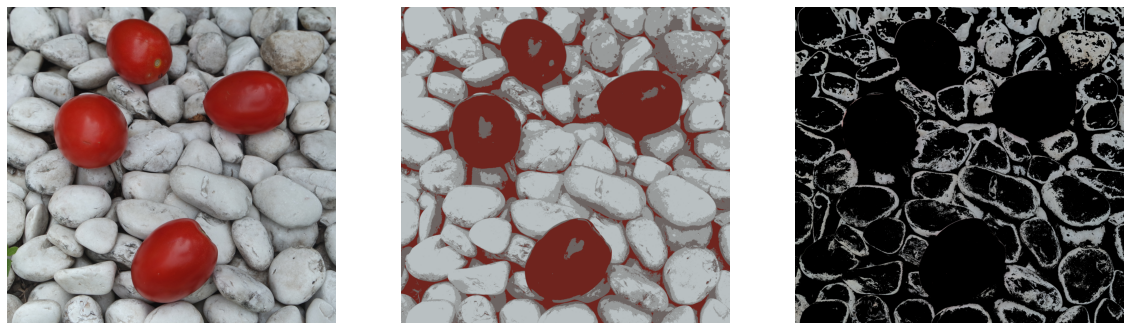

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageClustering = cv2.cvtColor(imageClustering, cv2.COLOR_BGR2RGB)
imageSeg = cv2.cvtColor(imageSeg, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(imageClustering)
axs[2].imshow(imageSeg)

for a in axs:
    a.set_axis_off()

plt.show()

In [ ]:
imageSeg = cv2.imread("imagenSegmentada.png")
imageClustering = cv2.imread("imageClustering.png")

# Saca bordes
# imageBorder = cv2.Canny(imageSeg, 0, 255)

imageGray = RGBGray(imageSeg, rows, cols) # Convierte imagen a escala de grises (NTSC)
expandedImage = expandImage(imageGray, sizeKernel, np.uint8) # Expande imagen 
passKernelImage = passKernel(imageGray, expandedImage, kernel, sizeKernel) # Pasamos el kernel por la imagen 
print("\nTamaño matriz: " + str(passKernelImage.shape[0]) + " x " + str(passKernelImage.shape[1]))

# Cruces por cero
expandedImage = expandImage(passKernelImage, 3, np.float64)
crossingZeroImage = crossingZero(passKernelImage, expandedImage, 3)

# delta = int(input("Ingresa un delta: "))
delta = 20
crossingZeroImageDelta = crossingZeroDelta(passKernelImage, expandedImage, 3, delta)
imageBorder = andImage(crossingZeroImage, crossingZeroImageDelta)

KeyboardInterrupt: 

In [ ]:
borders = []
for i in range(rows):
    for j in range(cols):
        if imageBorder[i, j] == 255:
            borders.append(np.array([i, j]))
borders = np.array(borders)
# print("Bordes:\n", borders)

# Segmenta la imagen para sacar los bordes de cada objeto
k = 4 # Numero de objetos en la imagen 
maxIterations = 100 # Iteraciones maximas para el algoritmo 
features = 2 # Tamaño de cada vector
clusters, _ = KMeans(k, maxIterations, features, borders, borders.shape[0])

In [ ]:
# Obtenemos cada objeto
objects = [] 
for i in range(k): # k = numero de objetos
    objects.append(borders[clusters[i]])
# print(objects[0])
# Object 1 y 2 los que requerimos

imageObjectSeg = imageBorder.copy()
for i in [0, 2, 3]:
    for index in objects[i]:
        imageObjectSeg[index[0], index[1]] = np.uint8(0)

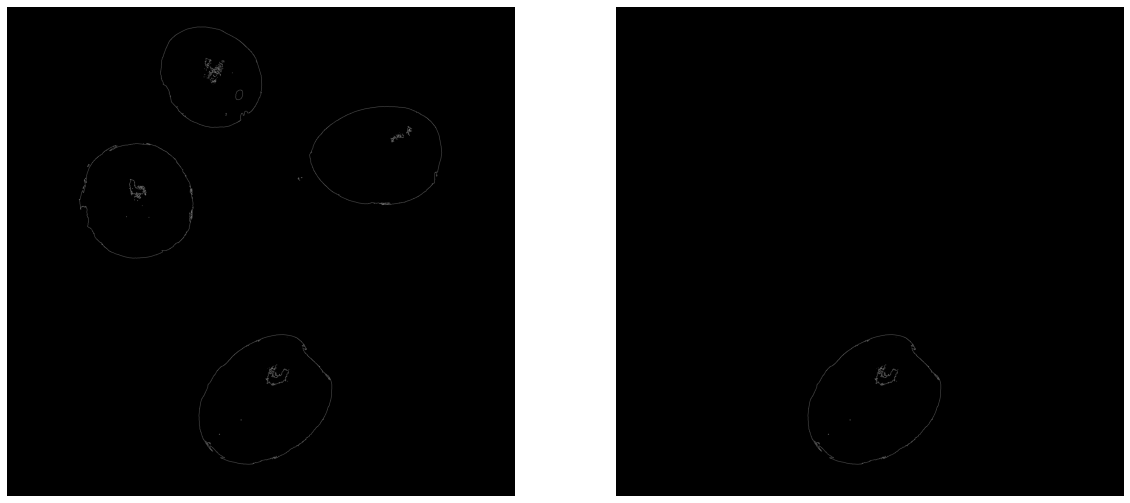

In [ ]:

# cv2.imshow("Imagen segmentada escala de grises", imageGray)
# cv2.imshow("Imagen con bordes", imageBorder)
# cv2.imshow("Imagen con un objeto", imageObjectSeg)
# cv2.waitKey(0)

imageBorder = cv2.cvtColor(imageBorder, cv2.COLOR_BGR2RGB)
imageObjectSeg = cv2.cvtColor(imageObjectSeg, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(imageBorder, cmap='gray')
axs[1].imshow(imageObjectSeg, cmap='gray')

for a in axs:
    a.set_axis_off()

plt.show()

In [ ]:
def f(l, x):
    y = -(l[0]*x + 1) / l[1]
    return y 

def getPoint(indexMiddleX):
    indexindexMiddleY = [] # Saca los pixeles donde intersecta la columnas con la fila 
    for indexY in objects[1]:
        if indexY[0] == indexMiddleX:
            indexindexMiddleY.append(indexY[1])
    # print(indexindexMiddleY)
    
    return indexindexMiddleY

# Puntos del objeto 1
indexMinX = objects[1][0][0]
indexMaxX = objects[1][-1][0]
indexMiddleX = int((indexMaxX - indexMinX) / 2) + indexMinX # Encuentra fila de en medio
indexMiddleX1 = int((indexMiddleX - indexMinX) / 2) + indexMinX # Encuentra fila de en medio entre la de en medio y la primera fila
indexMiddleX2 = int((indexMaxX - indexMiddleX) / 2) + indexMiddleX # Encuentra fila de en medio entre la de en medio y la ultima fila
# print(indexMiddleX2)
# print(indexMiddleX1)

indexindexMiddleY = getPoint(indexMiddleX2 + 60) # Saca los extremos a tanteo
m1 = np.array([indexMiddleX2 + 80, indexindexMiddleY[0]])
indexindexMiddleY = getPoint(indexMiddleX1 - 40)
m2 = np.array([indexMiddleX1 - 40, indexindexMiddleY[-1]])
print("Puntos:", m1, m2)

distance = euclideanDistance(m1, m2)
print("Distancia entre m1 y m2 en pixeles:", int(distance))

imageFinal = image.copy()
# imageFinal = cv2.line(imageFinal, (m1[1], m1[0]), (m2[1], m2[0]), (255, 165, 0), 10)

# Crea el vector de la linea
m1 = np.array([m1[0], m1[1], 1])
m2 = np.array([m2[0], m2[1], 1])
l1 = np.cross(m1, m2)
l1 = l1 / l1[2]

# Pinta la linea
i = m1[0]
while 1:
    j = int(f(l1, i))
    imageFinal[i, j] = np.uint8(np.array([0, 165, 255]))
    for k in range(1, 6):
        imageFinal[i - k, j] = np.uint8(np.array([0, 165, 255]))
        imageFinal[i + k, j] = np.uint8(np.array([0, 165, 255]))
    i -= 1
    if i < m2[0] - k:
        break

Puntos: [2450 1106] [1968 1702]
Distancia entre m1 y m2 en pixeles: 766


In [ ]:
# Puntos del objeto 2
indexMinX = objects[2][0][0]
indexMaxX = objects[2][-1][0]
indexMiddleX = int((indexMaxX - indexMinX) / 2) + indexMinX # Encuentra fila de en medio

indexindexMiddleY = [] # Saca los pixeles donde intersecta la columnas con la fila de en medio
for indexY in objects[2]:
    if indexY[0] == indexMiddleX:
        indexindexMiddleY.append(indexY[1])
m1 = np.array([indexMiddleX, indexindexMiddleY[0]])
m2 = np.array([indexMiddleX, indexindexMiddleY[1]])
print("Puntos:", m1, m2)

distance = euclideanDistance(m1, m2)
print("Distancia entre m1 y m2 en pixeles:", int(distance))

# imageFinal = image.copy() # Pinta una linea de grosor de 20 pixeles del punto m1 al m2
i = indexMiddleX - 5
while 1:
    j = indexindexMiddleY[0]
    while 1:
        imageFinal[i, j] = np.uint8(np.array([255, 165, 0]))
        j += 1
        if j > indexindexMiddleY[1]:
            break
    i += 1
    if i > indexMiddleX + 5:
        break

Puntos: [ 828 1687] [ 828 2422]
Distancia entre m1 y m2 en pixeles: 735


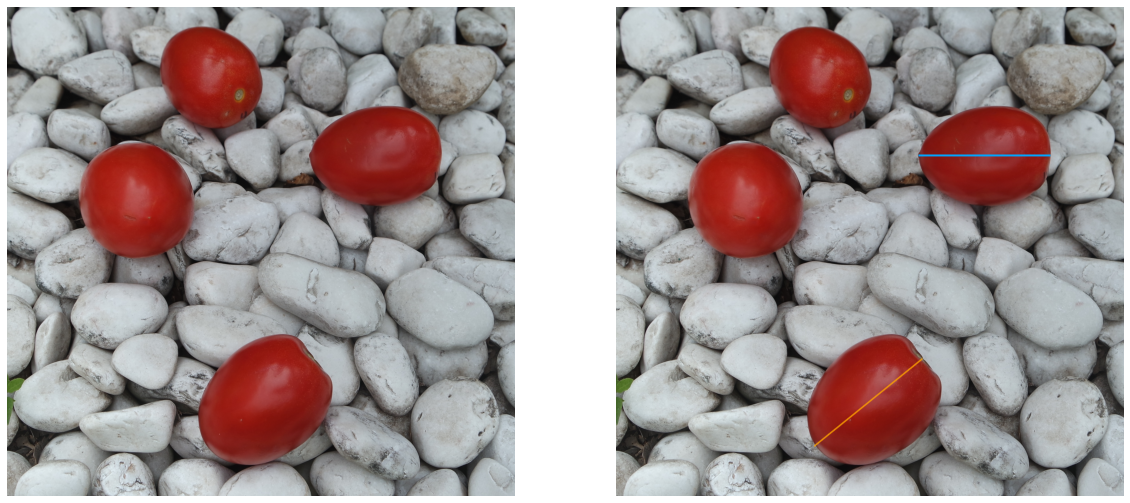

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageFinal = cv2.cvtColor(imageFinal, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(imageFinal, cmap='gray')

for a in axs:
    a.set_axis_off()

plt.show()